In [1]:
from typing import List, Mapping
from itertools import zip_longest, chain
from glob import iglob
from pickle import load
from functools import partial, reduce

from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import numpy as np
from numpy.random import normal, choice, rand
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt
from h5py import File

from vmitools import (
    abel_inverse, finite_legendre_transform_in_theta,
    interp, tohist, transpose_linearly, transpose_to_drdomega, transpose_to_drdth,
    mrot, mhorshear, msqueeze,
)

In [2]:
runs = range(299, 306+1)
filenames = sorted(chain.from_iterable(iglob(f"/data/*/Run_{r:03d}/work/reduced.pickle") for r in runs if not r in {}))
print(f"Total {len(filenames)} files:")
for fn in filenames:
    print(f"    {fn}")

Total 6 files:
    /data/Step601N2/Run_299/work/reduced.pickle
    /data/Step601N2/Run_300/work/reduced.pickle
    /data/Step601N2/Run_301/work/reduced.pickle
    /data/Step601N2/Run_303/work/reduced.pickle
    /data/Step601N2/Run_305/work/reduced.pickle
    /data/Step601N2/Run_306/work/reduced.pickle


In [3]:
def read_file(filename):
    with open(filename, 'br') as f:
        return load(f)


sumup = partial(reduce, partial(pd.DataFrame.add, fill_value=0))
summed = sumup(read_file(fn) for fn in filenames)
summed

sum    count
is_bg delay atmax                                                            
False -6.7  555    [[109.0, 117.0, 103.0, 106.0, 111.0, 107.0, 10...      1.0
            560    [[2099.0, 2095.0, 2097.0, 2130.0, 2142.0, 2073...     20.0
            565    [[107474.0, 106496.0, 106587.0, 107935.0, 1084...   1007.0
            570    [[1005684.0, 1000585.0, 997636.0, 1010745.0, 1...   9399.0
            575    [[2870712.0, 2853373.0, 2848771.0, 2885223.0, ...  26930.0
            580    [[3872699.0, 3841760.0, 3845840.0, 3892393.0, ...  36669.0
            585    [[2086314.0, 2068620.0, 2072085.0, 2095798.0, ...  19764.0
            590    [[1837473.0, 1825181.0, 1825396.0, 1846829.0, ...  17350.0
            595    [[553077.0, 549717.0, 549195.0, 556229.0, 5591...   5218.0
            600    [[132988.0, 131928.0, 132064.0, 133671.0, 1342...   1261.0
            605    [[525.0, 539.0, 522.0, 541.0, 523.0, 524.0, 52...      5.0
True  -6.7  560    [[1065.0, 1043.0, 1048.0, 1046.0, 1079.0, 1029...     10.0
            565    [[59965.0, 59467.0, 59598.0, 60388.0, 60323.0,...    571.0
            570    [[485209.0, 480783.0, 481891.0, 487536.0, 4895...   4622.0
            575    [[1396630.0, 1382204.0, 1387564.0, 1402011.0, ...  13322.0
            580    [[1939616.0, 1919137.0, 1928091.0, 1948366.0, ...  18539.0
            585    [[1023526.0, 1012401.0, 1016996.0, 1027551.0, ...   9765.0
            590    [[923768.0, 913921.0, 918429.0, 927345.0, 9317...   8821.0
            595    [[267019.0, 264864.0, 265894.0, 268308.0, 2696...   2560.0
            600    [[62085.0, 61174.0, 61759.0, 62359.0, 62622.0,...    596.0
            605    [[313.0, 308.0, 310.0, 310.0, 309.0, 309.0, 30...      3.0

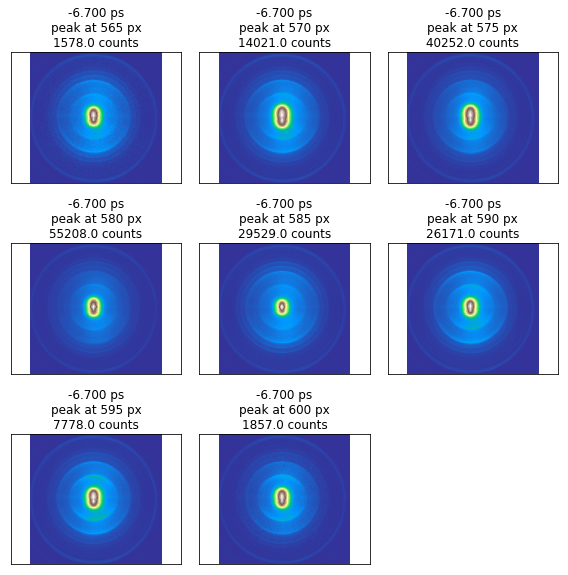

In [5]:
def good_img(img):
    return not np.isnan(img).any()


n = summed['count'].loc[False] + summed['count'].loc[True]
avg = summed['sum'] / summed['count']
diff = (avg.loc[False] - avg.loc[True])
where = (50 < n) & (diff.apply(good_img))
df = pd.DataFrame({
    'img': diff[where].apply(partial(np.einsum, 'ij->ji')),
    'n': n[where],
})

plt.figure(figsize=(8, 16))
for i, ((dt, atmax), img, n) in enumerate(df[['img', 'n']].itertuples()):
    plt.subplot(6, 3, i+1)
    plt.title(f"{dt:.3f} ps\npeak at {atmax} px\n{n} counts")
    plt.pcolormesh(img.T, cmap='terrain')
    plt.axis("equal")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.clim(0, None)
plt.tight_layout()
plt.show()

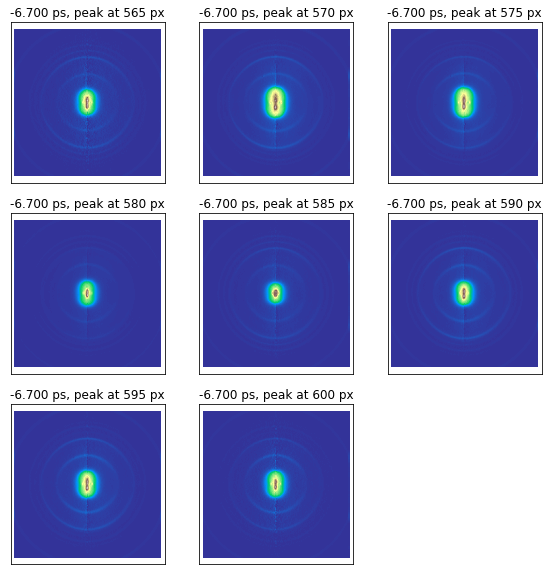

In [6]:
zedges = np.arange(-400, 400 + 1)
redges, thedges = np.linspace(0, 400, 400 + 1), np.linspace(-np.pi, np.pi, 360 + 1)
r = (redges[1:] + redges[:-1]) / 2
th = (thedges[1:] + thedges[:-1]) / 2


def invert_img(d):
    img = d['img']
    img = gaussian_filter(img, 2)
    xn, yn = img.shape
    xedges = np.arange(xn + 1)
    yedges = np.arange(yn + 1)
    f = interp(img, xedges, yedges)
    g = transpose_linearly(f, np.eye(2), x0=np.array([437, 458]))
    transformed = tohist(g, zedges, zedges)

    dz = zedges[1:] - zedges[:-1]
    inverted = abel_inverse(transformed, zedges) * dz[None, :]  # shape: (r, z)
    sliced = interp(inverted, zedges, zedges)  # (rho, z) -> intensity
    hist_indrdomega = tohist(transpose_to_drdomega(sliced), redges, thedges)  # (r, th) -> intensity
    hist_indrdth = tohist(transpose_to_drdth(sliced), redges, thedges)  # (r, th) -> intensity
    return pd.Series({
        'inverted': inverted,
        'hist_indrdth': hist_indrdth,
        'hist_indrdomega': hist_indrdomega,
    })


df = df.merge(df.apply(invert_img, axis=1), left_index=True, right_index=True)


plt.figure(figsize=(8, 16))
for i, ((dt, atmax), img, n) in enumerate(df[['inverted', 'n']].itertuples()):
    plt.subplot(6, 3, i+1)
    plt.title(f"{dt:.3f} ps, peak at {atmax} px")
    plt.pcolormesh(img.T, cmap='terrain')
    plt.axis("equal")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.clim(0, None)
plt.tight_layout()
plt.show()

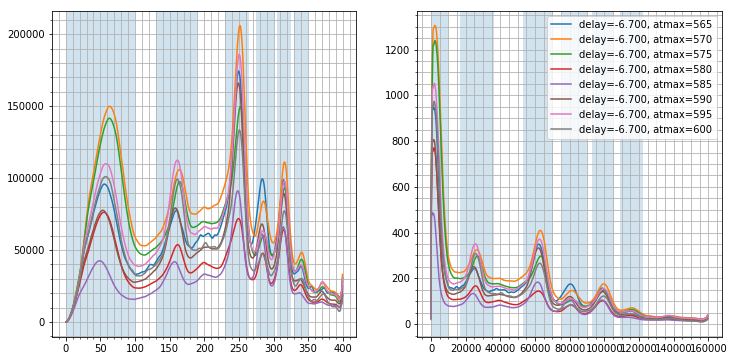

In [7]:
roi = [
    [0, 100],
    [130, 190],
    [230, 265],
    [275, 300],
    [305, 325],
    [330, 350],
]


def f(hist):
    return hist.sum(1)


def intergrateit(hist, fr, to, x=None, **kwargs):
    if x is None:
        x = np.arange(len(hist))
    where = (fr < x) & (x < to)
    return hist[where].sum(**kwargs)


def project_to_pn(hist, n):
    _, coeff, _ = finite_legendre_transform_in_theta(
        hist, thedges, n + 1,
    )  # Shapes of returns: (n, r) (n, r) (n, th)
    return coeff[n]/coeff[0]


for i, (fr, to) in enumerate(roi):
    df[f'summed{i}_rdist'] = df['hist_indrdth'].apply(intergrateit, fr=fr, to=to, x=r)
    df[f'summed{i}_pad'] = df['hist_indrdomega'].apply(intergrateit, fr=fr, to=to, x=r, axis=0)
    df[f'summed{i}_beta2'] = df[f'summed{i}_pad'].apply(project_to_pn, n=2)
    df[f'summed{i}_beta4'] = df[f'summed{i}_pad'].apply(project_to_pn, n=4)


plt.figure(figsize=(12, 6))
plt.subplot(121)
for (dt, atmax), dist in df['hist_indrdth'].apply(f).items():
    plt.plot(r, dist, label=f"delay={dt:.3f},atmax={atmax}")
plt.minorticks_on()
plt.grid(True, which='both')

for fr, to in roi:
    plt.axvspan(fr, to, alpha=0.2)

plt.subplot(122)
for (dt, atmax), dist in df['hist_indrdth'].apply(f).items():
    plt.plot(r**2, dist/2/r, label=f"delay={dt:.3f}, atmax={atmax}")
plt.minorticks_on()
plt.grid(True, which='both')

for fr, to in roi:
    plt.axvspan(fr**2, to**2, alpha=0.2)

plt.legend()
plt.show()

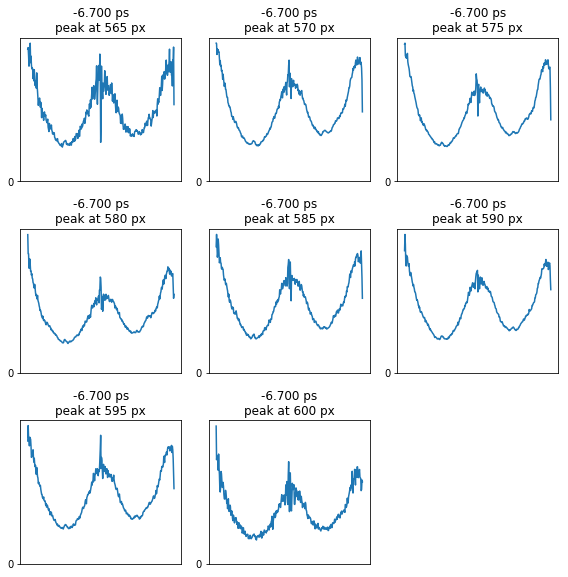

In [8]:
plt.figure(figsize=(8, 16))
for i, ((dt, atmax), pad) in enumerate(df['summed2_pad'].items()):
    plt.subplot(6, 3, i+1)
    plt.title(f"{dt:.3f} ps\npeak at {atmax} px")
    plt.plot(th, pad)
    plt.xticks([], [])
    plt.yticks([0], [0])
    plt.ylim(0, None)
plt.tight_layout()
plt.show()

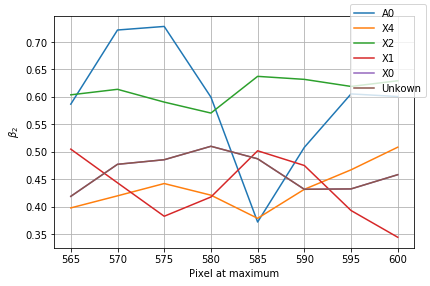

In [9]:
at = df.index[0][0]


def norm(arr):
    return arr/arr.sum()


plt.figure()
plt.xlabel("Pixel at maximum")
plt.ylabel(r"$\beta_2$")
plt.plot(df.loc[at]['summed0_beta2'], label='A0')
plt.plot(df.loc[at]['summed1_beta2'], label='X4')
plt.plot(df.loc[at]['summed2_beta2'], label='X2')
plt.plot(df.loc[at]['summed3_beta2'], label='X1')
plt.plot(df.loc[at]['summed4_beta2'], label='X0')
plt.plot(df.loc[at]['summed4_beta2'], label='Unkown')
# plt.ylim(0, None)
plt.grid(True)
plt.figlegend()
plt.tight_layout()
plt.show()

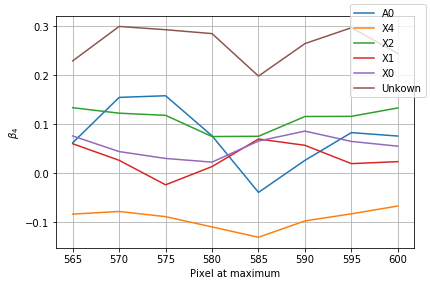

In [10]:
at = df.index[0][0]


def norm(arr):
    return arr/arr.sum()


plt.figure()
plt.xlabel("Pixel at maximum")
plt.ylabel(r"$\beta_4$")
plt.plot(df.loc[at]['summed0_beta4'], label='A0')
plt.plot(df.loc[at]['summed1_beta4'], label='X4')
plt.plot(df.loc[at]['summed2_beta4'], label='X2')
plt.plot(df.loc[at]['summed3_beta4'], label='X1')
plt.plot(df.loc[at]['summed4_beta4'], label='X0')
plt.plot(df.loc[at]['summed5_beta4'], label='Unkown')
# plt.ylim(0, None)
plt.grid(True)
plt.figlegend()
plt.tight_layout()
plt.show()

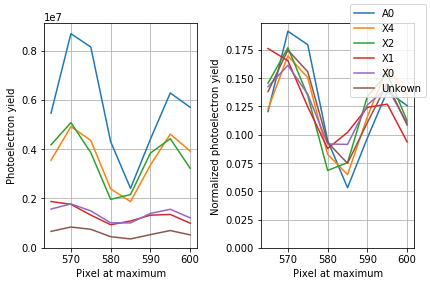

In [11]:
at = df.index[0][0]


def norm(arr):
    return arr/arr.sum()


plt.figure()
plt.subplot(121)
plt.xlabel("Pixel at maximum")
plt.ylabel("Photoelectron yield")
plt.plot(df.loc[at]['summed0_rdist'], label='A0')
plt.plot(df.loc[at]['summed1_rdist'], label='X4')
plt.plot(df.loc[at]['summed2_rdist'], label='X2')
plt.plot(df.loc[at]['summed3_rdist'], label='X1')
plt.plot(df.loc[at]['summed4_rdist'], label='X0')
plt.plot(df.loc[at]['summed5_rdist'], label='Unkown')
plt.ylim(0, None)
plt.grid(True)
plt.figlegend()

plt.subplot(122)
plt.xlabel("Pixel at maximum")
plt.ylabel("Normalized photoelectron yield")
plt.plot(norm(df.loc[at]['summed0_rdist']), label='A0')
plt.plot(norm(df.loc[at]['summed1_rdist']), label='X4')
plt.plot(norm(df.loc[at]['summed2_rdist']), label='X2')
plt.plot(norm(df.loc[at]['summed3_rdist']), label='X1')
plt.plot(norm(df.loc[at]['summed4_rdist']), label='X0')
plt.plot(norm(df.loc[at]['summed5_rdist']), label='Unkown')
plt.ylim(0, None)
plt.grid(True)
# plt.figlegend()
plt.tight_layout()
plt.show()